# Simulation du modèle des prisonniers

Ce modèle est décrit dans "Diffusivity of a random walk on random walks" de Emmanuel Boissard, Serge Coher, Thibault Espinasse et James Norris (BCEN).

In [1]:
#bibliothèques utilisées dans les codes suivants
from numpy import *
from matplotlib.pyplot import *
import random as rdm
import time

# Méthode classique

On souhaite simuler le comportement du processus aléatoire décrit dans BCEN, à partir de sa définition. La première étape est donc de simuler la chaîne de prisonniers au temps $n=0$, i.e. sous la mesure invariante. Pour ce faire nous allons utiliser la description séquentielle pour générer deux listes de caractères valant $\pm 1$ correspondant aux valeurs de $Y_K(0)$ et $Y_K(1)$, ainsi qu'une variable epsilon qui contient la valeur de $A_K(\Delta_0)$.

In [2]:
#On va utiliser la description séquentielle pour générer une arête de G_K
#distribuée sous la mesure invariante
def description_sequentielle(K):
    epsilon=2*rdm.randint(0,1)-1 #On tire une Rademacher pour epsilon
    a=[]#On initialise les listes de coordonnées
    b=[]
    gamma=epsilon #On initialise la valeur de gamma
    for i in range(K): #Pour chaque coordonnée (i va de 0 à K-1)...
        alpha=rdm.random() #... on tire un nombre uniformément sur [0,1] qui
        #va déterminer la valeur de alpha_i
        if alpha>1.0/3.0: #Comme alpha_i est une Bernoulli de paramètre 1/3,
            #on considère alpha_i=indicatrice(aléa<1/3).
            #Si alpha_i=0, alors la coordonnée ne change pas de a à b et vaut beta
            beta=2*rdm.randint(0,1)-1 #beta est une Rademacher
            a.append(beta)
            b.append(beta)
        else:
            #Si alpha_i=1, alors la coordonnée change et vaut +/- gamma_i
            a.append(gamma) #gamma_i pour a
            gamma=-1*gamma #On met à jour gamma en changeant son signe
            b.append(gamma) #gamma_(i+1)=-gamma_i pour b
    return [[a, b],epsilon]
#On renvoie a et b qui sont les configurations des prisonniers aux temps n=0 et n=1,
#ainsi que la valeur de epsilon i.e. A_K(a,b) (indispensable en cas de boucle).

Nous possédons maintenant une fonction qui donne les deux premières configurations de notre chaîne de prisonniers (ainsi que la valeur de $A_K(\Delta_0)$). Pour pouvoir itérer le processus, il suffit alors de lister les configurations valides avant d'en tirer une au hasard. Nous allons construire cette liste à partir des coordonnées de $a\in V_K$ en raisonnant par troncature : en effet si $\tilde{a}_k$ et $\tilde{b}_k$ désignent les sommets de $V_k$ obtenus en prenant les $k$ premières coordonnées de $a$ et $b$ respectivement (pour $k<K$), alors $(a,b)\in E_K \Rightarrow (\tilde{a}_k,\tilde{b}_k)\in E_k$, et la réciproque demande une compatibilité de signes que nous pouvons vérifier.

On commence à partir d'une boucle sur l'unique sommet $v_0\in V_0$ (en mettant $0$ pour la valeur de $A_K$ afin d'indiquer qu'il s'agit d'une boucle qui ne change aucune coordonnée), puis pour $k=0,\dots,K-1$ on énumère les voisins de $\tilde{a}_{k+1}$ à partir des voisins de $\tilde{a}_k$. Tout d'abord la boucle (marquée jusqu'ici par un $0$) engendre deux voisins pour $\tilde{a}_{k+1}$ : la nouvelle boucle $(\tilde{a}_{k+1},\tilde{a}_{k+1})$ (toujours marquée par $0$) et l'arête qui ne change que la dernière coordonnée de $\tilde{a}_{k+1}$ (en prenant soin de préciser la valeur de $A_K$ fixée par ce changement). En revanche un autre voisin $\tilde{b}_k\neq \tilde{a}_k$ (qui possède un ou plusieurs changements de coordonnées) permettra de construire une ou deux arêtes dans $V_{k+1}$ selon le signe de $a_{k+1}$ : celle allant de $\tilde{a}_{k+1}$ à $(\tilde{b}_k ; a_{k+1})$ qui ne change pas la dernière coordonnée (ce qui est forcément une arête dans $E_{k+1}$) et éventuellement celle qui va jusqu'au sommet $\tilde{b}_{k+1}=(\tilde{b}_k ;- a_{k+1})$ et qui change aussi la $(k+1)$-ème coordonnée (seulement dans le cas où $a_{k+1}$ est du signe opposé au dernier changement de coordonnée dans $(\tilde{a}_k,\tilde{b}_k)$). Une fois que cette récurrence arrive à l'étape $K$ on s'arrête et on duplique la boucle pour avoir $(a,a)^+$ et $(a,a)^-$.

Pour savoir si $(\tilde{a}_{k+1},\tilde{b}_{k+1})\in E_{k+1}$, il faut que l'une des deux conditions suivantes soit remplie :
- l'arête $(\tilde{a}_{k},\tilde{b}_{k})$ change un nombre pair de coordonnées, donc $\sum_{i=1}^{k}(a_i-b_i)=0$ (car les signes des changements doivent alterner) et $a_{k+1}=\varepsilon=A_k(\tilde{a}_{k},\tilde{b}_{k})$,
- l'arête $(\tilde{a}_{k},\tilde{b}_{k})$ change un nombre impair de coordonnées, donc $\sum_{i=1}^{k}(a_i-b_i)=2\varepsilon$ (car les signes des changements doivent alterner) et $a_{k+1}=-\varepsilon$.

Par exhaustion des cas possibles on remarque que l'on peut réduire ces deux conditions en une seule, à savoir $\sum_{i=1}^{k}(a_i-b_i)+a_{i+1}=\varepsilon$, condition que nous utilisons dans le progamme suivant pour voir si l'arête $(\tilde{a}_{k+1},\tilde{b}_{k+1})$ est bien dans $E_{k+1}$.

In [3]:
#Liste des sommets voisins de a dans G_K
def liste_voisins(a):
    K=len(a) #On commence par récupérer la valeur de K à partir de la taille de a
    liste=[[0]] #L'initialisation est la boucle (on note epsilon=0 pour garder en tête 
    # les deux boucles en même temps) autour du sommet vide (K=0, aucune coordonnées)
    for i in range(K): #Procédons coordonnée par coordonnée (avec i allant de 0 à K-1)
        for j in range(len(liste)): #On parcourt tous les "voisins" dans la liste
            if liste[j][0]==0: #Le premier indice est epsilon
                #Le cas epsilon=0 correspond aux boucles,
                #on va donc créer la nouvelle liste "temp" à partir des deux
                #voisins ne changeant pas les premières coordonnées
                temp=[liste[j]+[a[i]]]+[[a[i]]+liste[j][1:]+[-a[i]]]
                #On ajoute donc la dernière coordonnée à la boucle, ainsi qu'un voisin 
                #où le premier changement est la (i+1)-ème coordonnée
            else: #Si on n'a pas 0 en début de ligne, c'est qu'une ou plusieurs
                #coordonnées ont déjà changé dans ce début de voisin
                #On ajoute le voisin ne changeant pas la coordonnée considérée
                temp.append(liste[j]+[a[i]])
                if sum(a[:i+1])-sum(liste[j][1:])==liste[j][0]:
                    #Si on peut changer la (i+1)-ème coordonnée en alternant les signes
                    #alors on ajoute le voisin obtenu en changeant ladite coordonnée
                    temp.append(liste[j]+[-a[i]])
        liste=temp #On met à jour la liste des "voisins" qui ont une coordonnée de plus
    #On n'oublie pas de doubler la boucle (a,a) en affectant les signes adéquats
    final = [[1]+liste[0][1:]] + [[-1]+liste[0][1:]] + liste[1:]
    return final

Nous pouvons à présent simuler notre processus aléatoire : il suffit d'appeler \verb+description_sequentielle+ pour intialiser le processus, puis on appelle \verb+liste_voisins+ pour avoir la liste des transitions possibles, on en tire une au hasard uniformément puis on réitère jusqu'à arriver au temps $n$.

La liste $Y$ gardera en mémoire tous les sommets de $V_K$ parcourus, tandis que $X$ listera les valeurs de $\sum_{i=0}^kA_K(\Delta_i)$, i.e. la position du premier marcheur au cours du temps.

In [4]:
#Simulation des n premières étapes de la marche aléatoire sur G_K
#et de la fonctionnelle additive correspondante
def marche_prisonniers_classique(n,K):
    start=description_sequentielle(K)
    #On tire les deux premiers sommets à l'aide de la description séquentielle
    Y=start[0] #Y sera la liste des sommets de V_K parcourus
    X=[0]+[start[1]] #X sera la trajectoire du premier marcheur du temps 0 au temps n
    for i in range(n-1): #On avance le temps jusqu'à n (i va de 0 à n-2)
        candidats=liste_voisins(Y[i+1]) #On liste tous les voisins du sommet actuel
        alpha=int(rdm.random()*len(candidats)) #On en tire un au hasard
        Y.append(candidats[alpha][1:]) #On ajoute le sommet à la liste Y
        X.append(X[i+1]+candidats[alpha][0])
        #On ajoute à la liste X sa dernière valeur incrémentée du signe de l'arête
    return [X,Y]

Nous pouvons à présent simuler la trajectoire du premier marcheur, tout en affichant le temps d'éxécution afin de comparer les différentes méthodes mises en place. Nous allons aussi nous servir de ces codes pour illustrer le comportement de cette "chaîne de prisonniers" en affichant la forme prise par cette chaîne lors des 5 premières étapes.

36.18676690000029


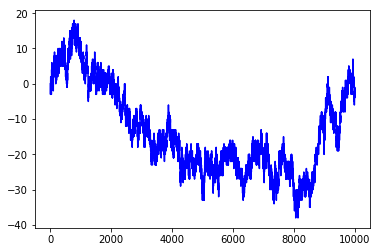

In [5]:
t1=time.perf_counter() #On retient la date du début de la simulation
M=marche_prisonniers_classique(10000,10) #On simule le processus via la méthode classique
plot(M[0],'blue') #On trace la trajectoire du premier marcheur au cours du temps
t2=time.perf_counter() #On récupère la date de fin de la simulation
print(t2-t1) #La différence des deux dates nous donne le temps d'éxécution

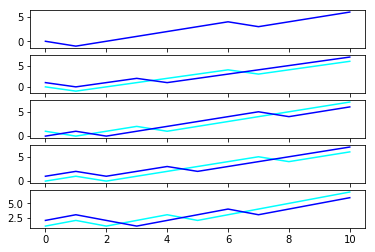

In [6]:
M=marche_prisonniers_classique(5,10) #On simule notre processus
#Puis on reconstruit les positions de tous les marcheurs à partir de la position
#du 1er marcheur X et la forme de la chaîne de prisonniers Y
C0 = cumsum([M[0][0]]+M[1][0])
C1 = cumsum([M[0][1]]+M[1][1])
C2 = cumsum([M[0][2]]+M[1][2])
C3 = cumsum([M[0][3]]+M[1][3])
C4 = cumsum([M[0][4]]+M[1][4])
#On affiche à chaque fois la forme actuelle et la forme précédente
subplot(511)
plot(C0,'blue')
subplot(512)
plot(C0,'cyan')
plot(C1,'blue')
subplot(513)
plot(C1,'cyan')
plot(C2,'blue')
subplot(514)
plot(C2,'cyan')
plot(C3,'blue')
subplot(515)
plot(C3,'cyan')
plot(C4,'blue')

# Méthode avec rejet

Le problème de la méthode précédente est que la liste des sommets voisins doit être refaite à chaque étape, et est longue à générer alors qu'on n'utilise qu'un seul élément dans cette liste. Quand $K$ devient très grand, il devient plus intéressant de ne pas lister les configurations accessibles, mais d'en tirer une au hasard dans $V_K$ jusqu'à en obtenir une valide. Pour cela il nous faut une fonction qui teste s'il y a une arête de $E_K$ entre deux éléments de $V_K$ donnés. Il suffit de parcourir les deux sommets coordonnée par coordonnée, de la dernière à la première, tout en gardant en mémoire le signe du dernier changement ayant eu lieu. Si tous les changements alternent leurs signes, on peut alors renvoyer $1$ pour indiquer qu'une arête reliant ces deux sommets existe dans $E_K$, ainsi que la valeur de $A_K$ correspondant au dernier changement lu (sauf dans le cas où les deux sommets sont égaux, où l'on renvoie $0$ pour indiquer que $A_K$ peut valoir $\pm 1$).

In [7]:
#Fonction booléenne indiquant si deux sommets (supposés venant du même graphe G_K) 
#sont voisins, et donnant le signe de l'arête (a,b) le cas échéant
def sont_voisins(a,b):
    signe=0 #Cette variable stockera le dernier changement de coordonnée repéré
    for i in range(len(a)-1,-1,-1): #On lit les coordonnées de droite à gauche
        #afin que le dernier changement de coordonnée identifié nous donne 
        #le signe de l'arête, donc i va de K-1 à 0
        diff=b[i]-a[i] #On calcule la différence des coordonnées
        if diff!=0: #Si les coordonnées sont différentes...
            if diff-signe==0: #... on compare avec le précédent changement
                #(0 si aucun changement n'a encore eu lieu)
                return [0,0] #Si deux changements consécutifs de coordonnées ont
            #le même signe, alors il n'y a pas d'arête entre a et b
            else: #Sinon on met à jour le dernier changement de coordonnée
                signe=diff 
    return [1, -signe/2] #Le facteur -1/2 permet de récupérer la valeur de A_K
#Attention ! cette fonction renvoie un "signe" égal à 0 si a=b

On peut ainsi coder une fonction de tirage qui va choisir des sommets au hasard dans $V_K$ jusqu'à tomber sur un voisin de $a\in V_K$, puis renvoyer ce sommet ainsi que la valeur de $A_K$ le long de l'arête correspondante (obtenue lors de la vérification). Il faut faire attention à doubler les chances de tirer le sommet où l'on se trouve actuellement lors du tirage car il y a deux boucles, $(a,a)^+$ et $(a,a,)^-$.
Nous allons donc tirer un sommet au hasard dans $V_K$ (en prenant garde de compter deux fois le sommet actuel, afin que la probabilité de tomber sur une boucle soit le double de celle de tomber sur une autre arête valide). Il suffit alors de tester s'il y a une arête permettant d'atteindre ce sommet et de mettre fin au tirage le cas échéant (sinon on recommence du début).

In [8]:
#Cette fonction va tirer un sommet au hasard dans V_K
#et réessayer jusqu'à tomber sur un voisin de v
def tirage(a):
    boucle=1 #Paramètre de boucle, vaudra 1 jusqu'à ce que le sommet tiré soit valide
    K=len(a) #On récupère la valeur de K à partir de la taille de a
    while boucle==1:#Début de la boucle principale
        alpha=rdm.randint(0,2**K) #On tire un entier aléatoire
        #compris entre 0 et 2^K INCLUS
        if alpha==2**K: #Si on tombe sur 2^K ...
            candidat=a #... on considère qu'on a tiré l'arête (v,v)^+
            signe=1
            boucle=0 #On arrête la boucle principale
        else:
            candidat=[] #On va écrire le candidat potentiel sous forme de coordonnées
            for i in range(K): #i va de 0 à K-1
                candidat.append((-1)**(alpha//2**(K-i-1))) #On ajoute une coordonnée
                #+1 ou -1 en fonction de l'écriture de alpha en binaire
                alpha= alpha-(alpha//2**(K-i-1))*2**(K-i-1) #On réduit alpha pour ne
                #garder que les chiffres les plus à droite dans son écriture en binaire
            test=sont_voisins(a,candidat) #On teste le candidat pour savoir s'il est
            #bien un voisin du sommet a
            if test[0]==1: #Si c'est le cas...
                boucle=0 #...on arrête la boucle principale
                if test[1]==0: #Si on est tombé sur a (i.e. le signe vaut 0)...
                    signe=-1 #...on considère qu'on est sur (a,a)^- 
                else: #Sinon l'arête correspondante est simplement (a,candidat)
                    signe=test[1] 
        #Si on a pas trouvé un voisin de a, le paramètre "boucle" vaut encore 1
        #donc on recommence du début de la boucle
    return [signe,candidat]

Il ne reste qu'à simuler notre processus : on utilise encore "description_sequentielle" pour initialiser le processus, puis on appelle simplement la fonction "tirage" pour itérer le processus à chaque étape.

A nouveau la liste $Y$ gardera en mémoire tous les sommets de $V_K$ parcourus, tandis que $X$ listera les valeurs de $\sum_{i=0}^k A_K(\Delta_i)$, i.e. la position du premier marcheur au cours du temps.

In [9]:
#Simulation des n premières étapes de la marche aléatoire sur G_K
#et de la fonctionnelle additive correspondante
def marche_prisonniers_rejet(n,K):
    start=description_sequentielle(K) #On tire les deux premiers sommets à l'aide
    #de la description séquentielle
    Y=start[0] #Y sera la liste des sommets de V_K parcourus
    X=[0]+[start[1]] #X sera la somme des A_K(Y_i,Y_(i+1))
    for i in range(n-1): #i va de 0 à n-2
        voisin=tirage(Y[i+1]) #On tire le sommet suivant à l'aide de la fonction tirage
        Y.append(voisin[1]) #On ajoute le sommet à la liste Y
        X.append(X[i+1]+voisin[0]) #On ajoute à la liste X sa dernière valeur
        #incrémentée du signe de l'arête
    return [X,Y]

Cette méthode devient plus avantageuse que la première pour $n$ grand, car en moyenne il est plus rapide de tomber sur un sommet voisin en tirant au hasard plutôt que de construire à chaque étape la liste des transitions valides. On peut effectivement voir ci-après que le temps d'éxécution est plus faible que pour la première méthode avec les mêmes paramètres ($n=10000$ et $K=10$).

2.00253739999971


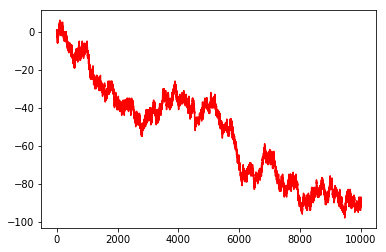

In [10]:
t1=time.perf_counter()#On retient la date du début de la simulation
M=marche_prisonniers_rejet(10000,10) #On simule notre processus via la méthode avec rejet
plot(M[0],'red') #On trace la trajectoire du premier marcheur au cours du temps
t2=time.perf_counter() #On récupère la date de fin de la simulation
print(t2-t1) #La différence des deux dates nous donne le temps d'éxécution

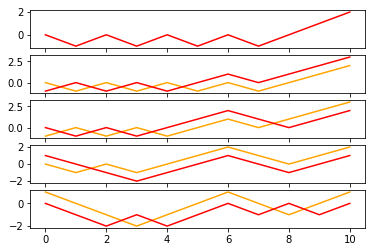

In [11]:
M=marche_prisonniers_rejet(5,10) #On simule notre processus
#Puis on reconstruit les positions de tous les marcheurs à partir de la position
#du 1er marcheur X et la forme de la chaîne de prisonniers Y
C0 = cumsum([M[0][0]]+M[1][0])
C1 = cumsum([M[0][1]]+M[1][1])
C2 = cumsum([M[0][2]]+M[1][2])
C3 = cumsum([M[0][3]]+M[1][3])
C4 = cumsum([M[0][4]]+M[1][4])
#On affiche à chaque fois la forme actuelle et la forme précédente
subplot(511)
plot(C0,'red')
subplot(512)
plot(C0,'orange')
plot(C1,'red')
subplot(513)
plot(C1,'orange')
plot(C2,'red')
subplot(514)
plot(C2,'orange')
plot(C3,'red')
subplot(515)
plot(C3,'orange')
plot(C4,'red')

# Méthode avec listes d'incidence

Puisqu'il s'agit d'une marche aléatoire sur un multi-graphe, la seule information dont nous avons besoin pour simuler le comportement de $(Y_K(n))_{n\geq 0}$ est la matrice d'incidence de $G_K$. D'une certaine manière cela revient à notre première méthode de simulation, mais en listant a priori toutes les listes de voisinage de manière à ne pas avoir besoin de les déterminer à nouveau à chaque étape.

Il s'avère que la fonctionnelle $A_K$ admet une propriété qui va nous être très utile : si $(u,v)\in E_K$ avec $u\neq v$ alors $A_K(u,v)=1$ (respectivement $-1$) ssi $u$ est placé après (resp. avant) $v$ pour l'ordre lexicographique ($u\underset{lex}{\prec}v$ ssi $\exists i=1,\dots,K$ tel que $u_i<v_i$ et $u_j=v_j$ pour $j<i$). Ainsi si on liste les sommets dans cet ordre on peut toujours très facilement déterminer la valeur de $A_K$. Nous allons donc générer la matrice $M_K=(M_{i,j})_{i,j\in \llbracket 1, 2^K\rrbracket}$ où $M_{i,j}$ vaut $1$ si les $i$-ème et $j$-ème sommets sont reliés par au moins une arête dans $E_K$, et $0$ sinon.

On pourrait croire que générer une telle matrice serait coûteux en temps d'éxécution, mais on peut exploiter la définition récursive des graphes $G_K$ pour obtenir cette matrice. En effet si on considère les relations de récurrence on constate que $M_{K+1}$ peut se décomposer en 4 blocs de taille $2^K\times 2^K$, ceux en haut à gauche et en bas à droite sont une copie conforme de $M_K$, tandis que celui en haut à droite (resp. en bas à gauche) est la partie triangulaire inférieure (resp. supérieure) de $M_K$. Une fois cette matrice $M$ calculée recursivement dans \verb+generation_matrice+ il ne reste plus qu'à lister les voisins de chaque sommet $j$ en ne conservant que les indices $i$ des colonnes telles que $M_{ij}=1$. 

In [12]:
def generation_matrice(K): #On génère la matrice d'incidence de manière récursive
    if K==0:
        return array([[1]]) #On démarre avec la matrice (1)
    else:
        X=generation_matrice(K-1)
        #On récupère la matrice du rang précédent
        TopLeft=X #Le bloc en haut à gauche est X
        TopRight=tril(X) #Le bloc en haut à droite ne conserve que le triangle inférieur
        BottomLeft=triu(X) #Le bloc en bas à gauche ne conserve que le triangle supérieur
        BottomRight=array(X) #Le bloc en bas à droite est une copie de X
        
        #Il ne reste plus qu'à assembler les 4 blocs
        return block([[TopLeft,TopRight],[BottomLeft,BottomRight]])

def liste_incidence(K): #On génère les listes de voisins
    matrice=generation_matrice(K) #On commence par construire la matrice d'incidence
    liste=[] #On initialise la double liste des voisins de chaque sommet
    for i in range(2**K): #Pour chaque sommet i entre 0 et 2^K-1...
        liste.append(where(matrice[i,:]==1)[0].tolist())
        #... on ajoute une liste contenant tous les indices j
        #tels que matrice[i][j] vaut 1
    return liste


Il nous faut à présent initialiser le processus au temps $n=0$, i.e. tirer un sommet sous la mesure invariante. On recode donc la fonction \verb+description_sequentielle+, mais cette fois-ci en utilisant le nouveau format utilisé pour représenter les éléments de $V_K$, à savoir un entier entre $0$ et $2^K-1$ (dont l'écriture en base 2 correspond aux coordonnées du sommet dans $V_K$). Notons qu'il faut changer la plage de valeurs des variables epsilon et beta afin de s'adapter à cette nouvelle description du modèle.

In [13]:
def initialisation(K):
    #On va utiliser la description séquentielle pour générer une arête de G_K
    #distribuée sous la mesure invariante,
    #mais cette fois-ci sous forme d'entiers et non sous forme de suites de +1/-1
    epsilon=rdm.randint(0,1) #On tire une Bernoulli pour epsilon
    a=0 #Les arêtes seront codées sous forme d'un entier et non d'une liste
    b=0 
    gamma=epsilon #On initialise le gamma
    for i in range(K): #Pour chaque coordonnée (i va de 0 à K-1)
        alpha=rdm.random() #On tire un aléa (uniforme sur [0,1]) 
        #pour déterminer la valeur de alpha_i
        if alpha>1.0/3.0: #Comme alpha_i est une Bernoulli de paramètre 1/3,
            #on considère alpha_i=indicatrice(aléa<1/3)
            #Si alpha_i=0, donc la coordonnée ne change pas de a à b
            #et on ajoute beta*2^(K-i-1)
            beta=rdm.randint(0,1)
            a=a+beta*2**(K-i-1)
            b=b+beta*2**(K-i-1)
        else:
            #Si alpha_i=1, donc la coordonnée change de gamma à -gamma
            a=a+gamma*2**(K-i-1) #+gamma_i pour a
            gamma=1-gamma #On update gamma en changeant son signe
            b=b+gamma*2**(K-i-1) #+gamma_(i+1)=-gamma_i pour b
    return [[a, b],2*epsilon-1]
#On renvoie a et b qui sont les conifgurations des prisonniers aux temps n=0 et n=1,
#ainsi que la valeur de 2*epsilon-1 i.e. A_K(a,b) (indispensable en cas de boucle).

A présent nous pouvons simuler le processus : on commence par générer les listes des voisins de chaque sommet $v\in V_K$ afin de pouvoir tirer un voisin au hasard, à l'instar de la méthode classique. On initialise la marche aléatoire à l'aide de la fonction \verb+initialisation+, puis on stockera les sommets parcourus dans $Y$ (sous forme d'entiers cette fois-ci) et la trajectoire du premier marcheur dans $X$. A chaque itération, on génère un entier $m$ aléatoire entre 1 et $deg(v)$ et on va chercher dans la matrice le $m$-ième voisin $w$ de $v$ ; il ne reste plus qu'à regarder si $w\underset{lex}{\prec}v$ ou non pour déterminer la valeur de $A_K$.

In [14]:
#Simulation des n premières étapes de la marche aléatoire sur G_K
#et de la fonctionnelle additive correspondante
def marche_prisonniers_incidence(n,K):
    voisins=liste_incidence(K)#On récupère les listes d'incidence 
    start=initialisation(K) #On tire les deux premiers sommets sous la mesure invariante
    Y=start[0] #Y sera la liste des sommets de V_K parcourus
    X=[0]+[start[1]] #X sera la somme des A_K(Y_i,Y_(i+1))
    sommet=Y[1] #On garde en mémoire le sommet où l'on se trouve actuellement...
    marcheur=X[1] #... ainsi que la position actuelle du premier marcheur
    for i in range(n-1): #i va de 0 à n-2
        N=len(voisins[sommet]) #On récupère le nombre de voisins du sommet actuel
        alea=rdm.random()*(N+1) #On génère un nombre uniformément sur [0, deg(v)]
        if alea>N: #S'il est dans l'intervalle ]N,N+1] on considère que l'on a tiré
            #la boucle (v,v)+, donc le marcheur monte et le sommet reste inchangé
            marcheur=marcheur+1
        else: #Sinon on va chercher le voisin tiré dans la liste
            arrivee=voisins[sommet][int(alea)]
            if arrivee<sommet: #Si le sommet d'arrivé est classé après celui de départ
                marcheur=marcheur+1 #alors l'arête est dans E_k^+ et le marcheur monte
            else: #Sinon elle est dans E_K^- (en incluant la boucle qui est (v,v)-)
                marcheur=marcheur-1 #donc le marcheur descend
            sommet=arrivee #On met à jour le sommet
        Y.append(sommet) #On ajoute le sommet actuel à la liste Y
        X.append(marcheur) #On ajoute la position actuelle à la liste X
    return [X,Y]

Si cette troisième méthode est trés rapide, surtout pour $n$ grand, elle présente un défaut qui compense son efficacité : la matrice d'incidence étant de taille $2^K\times 2^K$, elle réclame beaucoup de mémoire quand $K$ devient grand (c'est la raison pour laquelle nous comparons ces 3 méthodes avec $K=10$ seulement).

0.045161000000007334


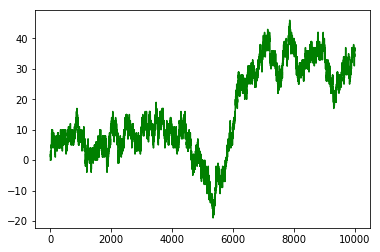

In [15]:
t1=time.perf_counter()#On retient la date du début de la simulation
M=marche_prisonniers_incidence(10000,10) #On simule notre processus via cette méthode
plot(M[0],'green') #On trace la trajectoire du premier marcheur au cours du temps
t2=time.perf_counter() #On récupère la date de fin de la simulation
print(t2-t1) #La différence des deux dates nous donne le temps d'éxécution